# NBA Shots Log Data EDA (DS-SF-25 | Final Project)

## Importing and Reading Data

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)

import seaborn as sns
import colorsys
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_dataset(x):
    return pd.read_csv(os.path.join('..', 'datasets', x))

df = read_dataset('shot_logs.csv')

In [3]:
df.head(2)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148


### The dataset has 21 variables. 'Shot_Result' and 'FGM' are the reponse variables. For the purpose of this project, shooter name and defender name will not be analyzed. The main purpose is to evaluate the quality of the shots; thus, who makes or defends the shots do not really matter.

In [4]:
df.columns

Index([u'GAME_ID', u'MATCHUP', u'LOCATION', u'W', u'FINAL_MARGIN',
       u'SHOT_NUMBER', u'PERIOD', u'GAME_CLOCK', u'SHOT_CLOCK', u'DRIBBLES',
       u'TOUCH_TIME', u'SHOT_DIST', u'PTS_TYPE', u'SHOT_RESULT',
       u'CLOSEST_DEFENDER', u'CLOSEST_DEFENDER_PLAYER_ID', u'CLOSE_DEF_DIST',
       u'FGM', u'PTS', u'player_name', u'player_id'],
      dtype='object')

## Datasets Dimension and NaN Drop

There are a total of 12,8069 observations. 5,567 were dropped with NaN, representing roughly 4% of the total observations.

In [5]:
df.shape

(128069, 21)

In [6]:
df.dropna(inplace = True)

In [7]:
df.shape

(122502, 21)

In [8]:
#number of observation being dropped and % as of total
print 128069-122502
print (128069-122502)/128069.

5567
0.0434687551242


## Datasets splitting

Two Pts and Three Pts

In the dataset, 74% of the shots are 2 pts with the remainder being 3 pts.

In [9]:
df.PTS_TYPE.value_counts()

2    90852
3    31650
Name: PTS_TYPE, dtype: int64

In [10]:
two_df= df[df['PTS_TYPE']==2]

In [11]:
three_df = df[df['PTS_TYPE']==3]

In [12]:
two_df.shape

(90852, 21)

In [13]:
three_df.shape

(31650, 21)

Train and Test split

In [14]:
train_2_df = two_df.sample(frac = .6, random_state = 0)
test_2_df = two_df.drop(train_2_df.index)

In [15]:
train_3_df = three_df.sample(frac = .6, random_state = 0)
test_3_df = three_df.drop(train_3_df.index)

## Data Exploration for Two Pointers

In [16]:
train_2_df.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,5.451100e+04,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000,54511.0,54511.000000,54511.000000,54511.000000,54511.000000,54511.000000
mean,2.140045e+07,0.059181,6.487443,2.442461,12.558131,2.349471,3.080083,9.637240,2.0,159021.495166,3.450751,0.488819,0.977638,156674.939553
std,2.579646e+02,13.248577,4.719303,1.137246,5.840915,3.556042,3.077456,6.833019,0.0,78685.519864,2.341734,0.499880,0.999759,80121.880480
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-100.500000,0.000000,2.0,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-9.000000,3.000000,1.000000,8.200000,0.000000,0.900000,3.700000,2.0,200745.000000,2.000000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,2.100000,7.400000,2.0,201948.000000,3.000000,0.000000,0.000000,201936.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.700000,3.000000,4.200000,16.300000,2.0,203079.000000,4.500000,1.000000,2.000000,202702.000000
max,2.140091e+07,53.000000,37.000000,7.000000,24.000000,32.000000,24.500000,43.300000,2.0,530027.000000,52.900000,1.000000,2.000000,204060.000000


### Response Variable

In [17]:
# To make sure 'FGM=1' represents shot made.
pd.crosstab(train_2_df.FGM, train_2_df.SHOT_RESULT)

SHOT_RESULT,made,missed
FGM,,
0,0,27865
1,26646,0


In [18]:
train_2_df.FGM.value_counts()

0    27865
1    26646
Name: FGM, dtype: int64

#### The overall field goal percentage is roughly 49% in the 2-point training set. The goal is to obtain a better prediction accuracy rate than 49%.

In [19]:
train_2_df.FGM.value_counts()[1]/float(train_2_df.shape[0])

0.48881877052338057

### Predictor Variable

In [20]:
# Add some color!
color = train_2_df.FGM.map(pd.Series({0: 'red', 1: 'green'}))

Game ID

The trainingset contains 896 games.

In [21]:
GameID_count = pd.value_counts(train_2_df.GAME_ID).to_frame().reset_index()

In [22]:
GameID_count.columns = ['ID', 'count']

In [23]:
GameID_count['ID'].count()

896

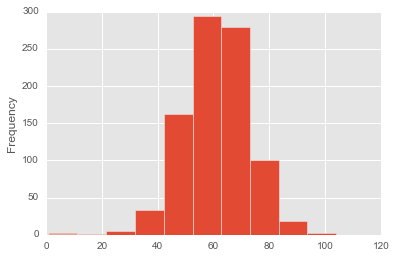

In [24]:
# it looks like some more shots are selected from a specific game than the others.
GameID_count['count'].plot(kind= 'hist')

In [25]:
train_2_df[['GAME_ID', 'FGM']].corr()

,GAME_ID,FGM
GAME_ID,1.000000,-0.006626
FGM,-0.006626,1.000000


MATCHUP

In [26]:
#Variable transformation
def mu_transform(mu):
    mu = mu.split(",")
    mu=mu[0]
    mu = mu.split(' ')
    mu_t=mu[0]
    return mu_t

In [27]:
train_2_df['Month']= train_2_df.MATCHUP.apply(mu_transform)

In [28]:
g = pd.value_counts(train_2_df['Month']).to_frame().reset_index()
g.columns = ['Month', 'count']

In [29]:
g = pd.value_counts(train_2_df['Month']).to_frame().reset_index()
g.columns = ['Month', 'count']

def graph(graph_title):

    sns.set_style("whitegrid")
    ax = sns.barplot(y = "", x = 'type', data=g)
    ax.set(xlabel = '', ylabel = '', title = graph_title)
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
graph('Distribution of employment length for issued loans')

ValueError: Could not interpret input 'type'

Location

In [30]:
train_2_df['LOCATION'].value_counts()

A    27273
H    27238
Name: LOCATION, dtype: int64

In [31]:
#transforming variable
train_2_df['location_t'] = 0
train_2_df.at[train_2_df['LOCATION'] == 'A','location_t'] = 1
test_2_df['location_t'] = 0
test_2_df.at[test_2_df['LOCATION'] == 'A','location_t'] = 1

It does look like shots are more likely to go in Home game although the difference is minor - 50.3% at home compared to 49.7%.

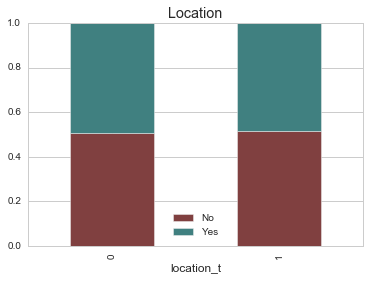

In [32]:
df_graph = pd.crosstab(train_2_df.location_t,train_2_df.FGM).apply(lambda r: r/r.sum(), axis=1)
N = len(train_2_df.location_t.value_counts().index)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
ax1 = df_graph.plot(kind="bar", stacked=True, color=RGB_tuples, title="Location")
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines,["No", "Yes"], loc='best')

In [33]:
df_graph

FGM,0,1
location_t,,
0,0.507673,0.492327
1,0.514685,0.485315


In [34]:
train_2_df[['location_t', 'FGM']].corr()

,location_t,FGM
location_t,1.000000,-0.007014
FGM,-0.007014,1.000000


Shot Number

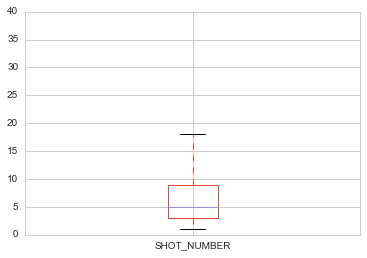

In [35]:
# It seems like majority of the players take less than 9 2-pts attempts in a game
train_2_df['SHOT_NUMBER'].plot(kind = 'box')

In [36]:
train_2_df['SHOT_NUMBER'].describe()

count    54511.000000
mean         6.487443
std          4.719303
min          1.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         37.000000
Name: SHOT_NUMBER, dtype: float64

In [37]:
train_2_df[['SHOT_NUMBER', 'FGM']].corr()

,SHOT_NUMBER,FGM
SHOT_NUMBER,1.000000,-0.004529
FGM,-0.004529,1.000000


Final Margin

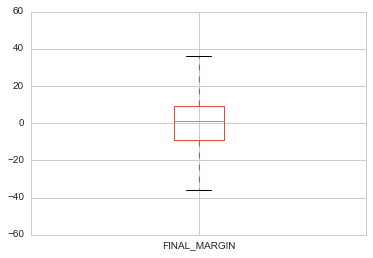

In [38]:
train_2_df['FINAL_MARGIN'].plot(kind = 'box')

In [ ]:
train_2_df['FINAL_MARGIN'].describe()

In [ ]:
train_2_df[['FINAL_MARGIN', 'FGM']].corr()

In [ ]:
# create a new variable indicating whether the final out is positie or not

Period

In [ ]:
train_2_df['PERIOD'].value_counts()

In [ ]:
train_2_df[['PERIOD', 'FGM']].corr()

Shot Clock

In [ ]:
def groupby_shotclock(x):
    if x <=6:
        return '0-6'
    elif x<=12:
        return '6-12'
    elif x<=18:
        return '12-18'
    else:
        return '18-24'
train_2_df['shot_clock']= train_2_df.SHOT_CLOCK.apply(groupby_shotclock)        

In [ ]:
train_2_df.groupby('SHOT_CLOCK')['FGM'].mean().plot()

In [ ]:
train_2_df[train_2_df['FGM']==1].SHOT_CLOCK.plot(kind = 'hist')

In [ ]:
train_2_df[train_2_df['FGM']==0].SHOT_CLOCK.plot(kind = 'hist')

In [ ]:
#ratio for a specific time interval

Game Clock

In [ ]:
#Variable transformation
def gc_transform(gc):
    gc = gc.split(":")
    gc0=float(gc[0])
    gc1=float(gc[1])
    gc0=gc0*60
    gc_t = gc1+gc0
    return gc_t

In [ ]:
train_2_df['GAME_CLOCK_t']= train_2_df.GAME_CLOCK.apply(gc_transform)
train_3_df['GAME_CLOCK_t']= train_3_df.GAME_CLOCK.apply(gc_transform)
test_2_df['GAME_CLOCK_t']= test_2_df.GAME_CLOCK.apply(gc_transform)
test_3_df['GAME_CLOCK_t']= test_3_df.GAME_CLOCK.apply(gc_transform)

In [ ]:
train_2_df['GAME_CLOCK_t'].describe()

In [ ]:
# 2pts
train_2_df.at[train_2_df['PERIOD'] <5,'GAME_CLOCK_t']= train_2_df['GAME_CLOCK_t']+(train_2_df.PERIOD-1)*720
train_2_df.at[train_2_df['PERIOD'] >4,'GAME_CLOCK_t']= train_2_df['GAME_CLOCK_t']+(train_2_df.PERIOD-5)*300+2880
test_2_df.at[test_2_df['PERIOD'] <5,'GAME_CLOCK_t']= test_2_df['GAME_CLOCK_t']+(test_2_df.PERIOD-1)*720
test_2_df.at[test_2_df['PERIOD'] >4,'GAME_CLOCK_t']= test_2_df['GAME_CLOCK_t']+(test_2_df.PERIOD-5)*300+2880

In [ ]:
# 3pts
train_3_df.at[train_3_df['PERIOD'] <5,'GAME_CLOCK_t']= train_3_df['GAME_CLOCK_t']+(train_3_df.PERIOD-1)*720
train_3_df.at[train_3_df['PERIOD'] >4,'GAME_CLOCK_t']= train_3_df['GAME_CLOCK_t']+(train_3_df.PERIOD-5)*300+2880
test_3_df.at[test_3_df['PERIOD'] <5,'GAME_CLOCK_t']= test_3_df['GAME_CLOCK_t']+(test_3_df.PERIOD-1)*720
test_3_df.at[test_3_df['PERIOD'] >4,'GAME_CLOCK_t']= test_3_df['GAME_CLOCK_t']+(test_3_df.PERIOD-5)*300+2880

In [ ]:
train_2_df['GAME_CLOCK_t'].describe()

In [ ]:
train_2_df['GAME_CLOCK_t'].plot(kind = 'hist')

In [ ]:
# take a test too see if OT impacts - do a radio for the game clock too
train_2_df[['GAME_CLOCK_t', 'FGM']].corr()

DRIBBLES

In [ ]:
train_2_df['DRIBBLES'].plot(kind = 'box')

In [ ]:
train_2_df[['DRIBBLES', 'FGM']].corr()

In [ ]:
train_2_df['Catch&Shot'] = 0
train_2_df.at[train_2_df['DRIBBLES'] == 0,'Catch&Shot'] = 1
test_2_df['Catch&Shot'] = 0
test_2_df.at[test_2_df['DRIBBLES'] == 0,'Catch&Shot'] = 1

In [ ]:
train_2_df[['Catch&Shot', 'FGM']].corr()

TOUCH_TIME

In [ ]:
train_2_df['TOUCH_TIME'].plot(kind = 'box')

In [ ]:
train_2_df[train_2_df['TOUCH_TIME']<0].TOUCH_TIME.count()

In [ ]:
train_2_df[['TOUCH_TIME', 'FGM']].corr()

In [ ]:
# Strong correlation between touch time and dribbles
train_2_df[['TOUCH_TIME', 'DRIBBLES']].corr()

Shot Distance

In [ ]:
train_2_df['SHOT_DIST'].plot(kind = 'hist')

In [ ]:
train_2_df[['SHOT_DIST', 'FGM']].corr()

CLOSE_DEF_DIST

In [ ]:
train_2_df['CLOSE_DEF_DIST'].plot(kind = 'hist')

In [ ]:
train_2_df[['CLOSE_DEF_DIST', 'FGM']].corr()

## Graphs and Viz

From individual variables exploration, it seems that the most significant variables include: PERIOD, FINAL_MARGIN,GAME_CLOCK, SHOT_CLOCK, DRIBBLES, TOUCH_TIME, SHOT_DIST and CLOSE_DEF_DIST

In [ ]:
train_2_df[['PERIOD', 'FINAL_MARGIN', 'SHOT_CLOCK','GAME_CLOCK_t', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'FGM']].corr()

In [ ]:
# it seems like there are some misclassifications between 2 and 3 pts
train_2_df.plot('SHOT_DIST', 'CLOSE_DEF_DIST', kind = 'scatter', c = color)

In [ ]:
train_2_df[train_2_df['SHOT_DIST']>23.75].count()

In [ ]:
# looking in the the arch and baseline
train_3_df.plot('SHOT_DIST', 'CLOSE_DEF_DIST', kind = 'scatter', c = color)

In [ ]:
train_3_df[train_3_df['SHOT_DIST']<22].count()

In [ ]:
train_2_df.plot('SHOT_CLOCK', 'SHOT_DIST', kind = 'scatter', c = color)

In [ ]:
train_2_df.plot('SHOT_CLOCK', 'GAME_CLOCK_t', kind = 'scatter', c = color)

In [ ]:
train_2_df.plot('FINAL_MARGIN', 'GAME_CLOCK_t', kind = 'scatter', c = color)